# Image Classification of Naira notes using Keras 

In [25]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
# This code assumes your CSV files are in a folder. It will print out the files in a folder and their unique identifiers which will be used below. 
# Replace <FOLDER ID> with the long string of numbers and letters in the URL of the folder in Google Drive. 
# If the files are located at the top level of Google Drive, replace <FOLDER ID> with ‘root’. The output should look like:

file_list = drive.ListFile({'q': "'1fnLoyJx-NIVXRu1MGOQ3T8T6H2pjLyfP' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Currencydata.zip, id: 1Elicap2WQ_EDO7weOrY7wtbh8SjU6mN-


In [0]:
dataset = drive.CreateFile({'id': '1Elicap2WQ_EDO7weOrY7wtbh8SjU6mN-'})
dataset.GetContentFile('Currencydata.zip')

In [14]:
!ls dataset/data/nigerianCurrencies

model  sample  test1  train  valid


In [13]:
!mkdir dataset
!unzip Currencydata.zip -d dataset/

Archive:  Currencydata.zip
   creating: dataset/data/
   creating: dataset/data/nigerianCurrencies/
   creating: dataset/data/nigerianCurrencies/model/
   creating: dataset/data/nigerianCurrencies/sample/
   creating: dataset/data/nigerianCurrencies/sample/train/
   creating: dataset/data/nigerianCurrencies/sample/train/N10/
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/01.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/02.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/03.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/04.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/05.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/06.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/08.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/21.jpg  
  inflating: dataset/data/nigerianCurrencies/sample/train/N10/22.jpg  
  inflating: dataset/data/nigerian

  inflating: dataset/data/nigerianCurrencies/test1/Naira9.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/Nigeria 10 Naira 2004.alt.300dpi.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/nigeria cash 6.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/Nigeria-10-Naira-P-39b-UNC-from-2010-Alvan.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/PicsJoin_20173190345815-300x300.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/Q.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/RAR.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/RARA.JPG  
  inflating: dataset/data/nigerianCurrencies/test1/RRS.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/s-l500.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/t5.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/TEN-NAIRA-OLD (1).jpg  
  inflating: dataset/data/nigerianCurrencies/test1/vllkyt1v568l08ldj8.c2d570de.jpg  
  inflating: dataset/data/nigerianCurrencies/test1/vllkyth

  inflating: dataset/data/nigerianCurrencies/valid/N1000/22.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N1000/24.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N1000/27.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N1000/31.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N1000/32.jpg  
   creating: dataset/data/nigerianCurrencies/valid/N20/
  inflating: dataset/data/nigerianCurrencies/valid/N20/02.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/04.gif  
  inflating: dataset/data/nigerianCurrencies/valid/N20/05.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/06.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/07.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/14.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/16.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/17.jpg  
  inflating: dataset/data/nigerianCurrencies/valid/N20/20.jpg  
  inflating: dataset/data/nigerianCurr

Now, lets Preprocess the image data

In [16]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 1.9MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import numpy as np
import cv2
import os
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
PATH = "dataset/data/nigerianCurrencies/"
image_list= os.listdir(PATH)
TRAIN_DIR = "dataset/data/nigerianCurrencies/train"
TEST_DIR = "dataset/data/nigerianCurrencies/test"
print(image_list)

['train', 'valid', 'sample', 'test1', 'model']


In [20]:
files = !ls {PATH}train/N200 | head
files

['01.jpg',
 '02.JPG',
 '03.jpg',
 '04.jpg',
 '05.jpg',
 '06.jpg',
 '07.jpg',
 '08.jpg',
 '09.jpg',
 '10.jpg']

(467, 800, 3)


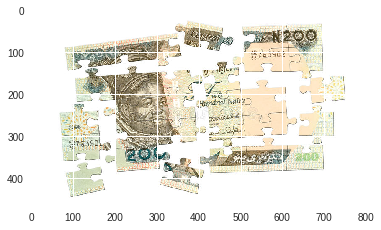

In [21]:
# this assigns the 2nd image in N200 folder in valid folder to a variable.img = plt.imread(f'{PATH}valid/N200/(files[2])') 
img = plt.imread(f'{PATH}train/N200/{files[2]}') 
# this will plot img
plt.imshow(img);
print(img.shape)

In [0]:
sz = (224,224)


def centering_image(img):
    size = [224,224]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

def create_train_set():
  x_train = []
  for img in tqdm(os.listdir(TRAIN_DIR)):
      #label = label_img(img)
      paths = os.path.join(TRAIN_DIR, img)          
      img = cv2.imread(paths, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, sz)
      traning_data.append([np.array(img),np])
      training_data.append([np.array(img),np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy', training_data)
  return training_data

In [0]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data


In [31]:
train_data = create_train_set()

  0%|          | 0/8 [00:00<?, ?it/s]


error: ignored